**Deep Autoencoder**

Use to encoder and autoencoder images with different sizes.

Install libs

In [0]:
# pip install PyYAML numpy matplotlib tensorflow

Import libs

In [0]:
# Numpy and Matplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Tensorflow and Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model, Sequential, load_model, model_from_yaml, model_from_json
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import *
#import tensorflow.keras.callbacks.Callback as Callback

import os
import json
import time
import datetime


Directories

In [0]:
data_png = './data_png'
data_npy = './data_npy/'
results_png = './results_png/'
metrics_png = './metrics_png/'
models_h5 = './models_h5/'
models_yml = './models_yml/'
shapes_sizes_json = './shapes_sizes_json/'
# dataset = './dataset'
# data = './data'


Utils

In [0]:
def plot_metrics_history_subplot(history, name):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot training & validation accuracy values
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_title('Model accuracy')
    ax1.legend(['Train', 'Test'], loc='upper right')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.legend(['Train', 'Test'], loc='upper right')

    fig.savefig(metrics_png + 'history_subplot_' + name)

def plot_metrics_history(history, name):    
    fig = plt.figure()
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    fig.savefig(metrics_png + 'history_acc_' + name)

    fig = plt.figure()
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    fig.savefig(metrics_png + 'history_loss_' + name)

def plot_metrics_evaluate_all(model, name):
    fig = plt.figure()

    loss = model[0]
    accuracy = model[1]

    plt.plot([0, 100], [0, loss * 100])
    plt.plot([0, 100], [0, accuracy * 100])
    plt.title('Loss: %.2f%% | Accuracy: %.2f%%' % ( loss * 100,  accuracy * 100 ))
    plt.legend(['Loss', 'Accuracy'], loc='upper right')
    plt.show()
    
    fig.savefig(metrics_png + 'evaluate_loss_accuracy' + name)

def plot_metrics_evaluate(model, name):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    loss = model[0]
    accuracy = model[1]

    ax1.plot([0, 100], [0, loss * 100])
    ax1.set_title('Loss: %.2f%%' % ( loss * 100 ))
    ax1.legend(['Loss'], loc='upper right')

    ax2.plot([0, 100], [0, accuracy * 100])
    ax2.set_title('Accuracy: %.2f%%' % ( accuracy * 100 ))
    ax2.legend(['Accuracy'], loc='upper right')
    
    fig.savefig(metrics_png + 'evaluate_acc_' + name)

def plot_all(images):
    fig = plt.figure(figsize=(32, 32))
    number_rows = int(len(images)/3) + 1
    
    for index in range(len(images)):
        a = fig.add_subplot(number_rows, 3, index+1)
        plt.imshow(images[index])
        plt.title(f'{index}:{images[index].shape}')
        a.axis('off')
    
    fig.savefig(results_png + 'compare_all_images.png')
    plt.show()

def save_image(name, image):        
    mpimg.imsave(results_png + name, image)

def save_npy(name, image): 
    name = name[:-4]
    np.save(data_npy + name + '.npy', image)

def save_json(name, shape): 
    name = name[:-4]

    data = {
        "shape_0": shape[0],
        "shape_1": shape[1],
        "shape_2": shape[2]
    }

    with open(shapes_sizes_json + 'original_' + name + '.json', 'w') as outfile:
        json.dump(data, outfile)

# def resized_images():
#     file = os.listdir(data)
#     size = sum(1 for img in file)

#     train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

#     train_generator = train_datagen.flow_from_directory(
#         data,
#         target_size=(256, 256),
#         save_to_dir=dataset,
#         batch_size=64,
#         class_mode='input',
#         color_mode='rgba')

#     index = 0
#     for batch in train_generator:
#         index += 1
#         if index <= size:
#             break

Class TimeHistory

In [0]:
class TimingCallback(Callback):
  def __init__(self):
    self.times = []
  def on_epoch_begin(self, epoch, logs={}):
    self.start_time = time.time()
  def on_epoch_end(self, epoch, logs={}):
    self.times.append(time.time() - self.start_time)

time_callback = TimingCallback()

Class DeepAutoencoder

In [0]:
class DeepAutoencoder(object):

    def __init__(self, input_dim, encoded_dim):
        
        input_layer = Input(shape=(input_dim,))
        hidden_input = Input(shape=(encoded_dim,))
        
        encoded = Dense(8 * encoded_dim, activation='relu')(input_layer)
        encoded = Dense(6 * encoded_dim, activation='relu')(encoded)
        encoded = Dense(4 * encoded_dim, activation='relu')(encoded)
        encoded = Dense(2 * encoded_dim, activation='relu')(encoded)
        hidden_layer = Dense(encoded_dim, activation='relu')(encoded)
        
#         Dropout(0.2)

        decoded = Dense(2 * encoded_dim, activation='relu')(hidden_layer)
        decoded = Dense(4 * encoded_dim, activation='relu')(decoded)
        decoded = Dense(6 * encoded_dim, activation='relu')(decoded)
        decoded = Dense(8 * encoded_dim, activation='relu')(decoded)
        output_layer = Dense(input_dim, activation='sigmoid')(decoded)
        
        self.autoencoder = Model(input_layer, output_layer)
        self.encoder = Model(input_layer, hidden_layer)
        
        # Encoder Layers
        encoder_layer1 = self.autoencoder.layers[-5]
        encoder_layer2 = self.autoencoder.layers[-4]
        encoder_layer3 = self.autoencoder.layers[-3]
        encoder_layer4 = self.autoencoder.layers[-2]
        encoder_layer5 = self.autoencoder.layers[-1]
                
        self.decoder = Model(hidden_input, 
        encoder_layer5(encoder_layer4(encoder_layer3(encoder_layer2(encoder_layer1(hidden_input))))))
        
        self.autoencoder.summary()
        self.encoder.summary()
        self.decoder.summary()

        self.autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, input_train, input_test, batch_size, epochs):    
        self.autoencoder.fit(input_train, input_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(input_test, input_test),
                            callbacks=[time_callback])
    
    def get_encoded_image(self, image):
        encoded_img = self.encoder.predict(image)
        return encoded_img
    
    def get_decoded_image(self, encoded_img):
        decoded_img = self.decoder.predict(encoded_img)
        return decoded_img

    def get_evaluate_model(self, train, test):
        autoencoder_evaluate = self.autoencoder.evaluate(train, test)
        return autoencoder_evaluate

    def get_history_model(self):
        autoencoder_history = self.autoencoder.history
        return autoencoder_history
    
    def save_model(self, name):
        name = name[:-4]
        self.autoencoder.save(models_h5 + 'autoencoder_' + name + '.h5')
        self.encoder.save(models_h5 + 'encoder_' + name + '.h5')
        self.decoder.save(models_h5 + 'decoder_' + name + '.h5')

    def save_model_to_yml(self, name):
        name = name[:-4]
        model_yaml = self.autoencoder.to_yaml()
        with open(models_yml + 'autoencoder_' + name + '.yaml', 'w') as yaml_file:
            yaml_file.write(model_yaml)

Class main()

In [0]:
def main():
    images = []
    historic = []
    results = []
    
    for img in os.listdir(data_png):
        try:
            # Normalização das imagens   
            img_train = mpimg.imread((os.path.join(data_png, img)))  
            max_train_value = float(img_train.max())
            train = img_train.astype('float32') / max_train_value
            train = train.reshape((len(train), np.prod(train.shape[1:])))
            
            img_test = mpimg.imread((os.path.join(data_png, img)))
            max_test_value = float(img_test.max())
            test = img_test.astype('float32') / max_test_value
            test = test.reshape((len(test), np.prod(test.shape[1:])))

            # Envio da imagem para a classe DeepAutoencoder
            autoencoder = DeepAutoencoder(train.shape[1], 64)
            autoencoder.train(train, test, 64, 1500)
            
            encoded_img = autoencoder.get_encoded_image(test)
            decoded_img = autoencoder.get_decoded_image(encoded_img)

            autoencoder_history = autoencoder.get_history_model()
            autoencoder_evaluate = autoencoder.get_evaluate_model(train, test)
            
            autoencoder.save_model(img)
            autoencoder.save_model_to_yml(img)
            
            plot_metrics_history(autoencoder_history, 'autoencoder' + img)
            plot_metrics_history_subplot(autoencoder_history, 'autoencoder' + img)
            plot_metrics_evaluate(autoencoder_evaluate, 'autoencoder' + img)
            plot_metrics_evaluate_all(autoencoder_evaluate, 'autoencoder' + img)

            # Dimensões da imagem original
            to_reshape = img_train.shape

            # Redimensionamento das imagens obtidas
            original_result = test.reshape(to_reshape[0], to_reshape[1], to_reshape[2])
            decoded_img_result = decoded_img.reshape(to_reshape[0], to_reshape[1], to_reshape[2])      

            images.append(original_result)
            images.append(encoded_img)
            images.append(decoded_img_result)

#            save_image('original_' + img, original_result)
            save_image('encoded_' + img, encoded_img)
            save_image('decoded_' + img, decoded_img_result)
            
            save_npy(img, encoded_img)
            save_json(img, img_train.shape)
            
            #Print average of the time for each layer
            results.append(np.average(time_callback.times))
            seconds = np.average(time_callback.times)
            result_time = str(datetime.timedelta(seconds=seconds))
            print("Medium time:", result_time)	

        except Exception as e:
            print(e)
            pass
    
    return images

Iteration about images of Satellite

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_100 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_101 (Dense)            (None, 384)               196992    
_________________________________________________________________
dense_102 (Dense)            (None, 256)               98560     
_________________________________________________________________
dense_103 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_104 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_105 (Dense)            (None, 128)               832

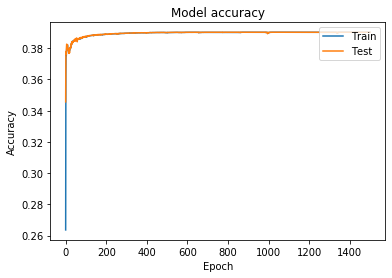

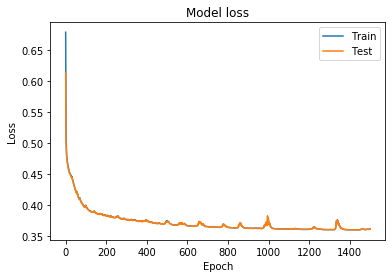

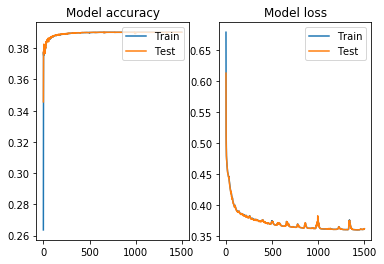

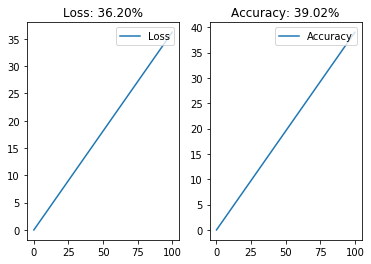

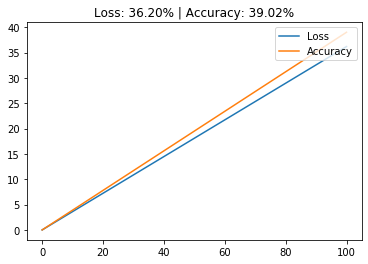

Medium time: 0:00:00.164412


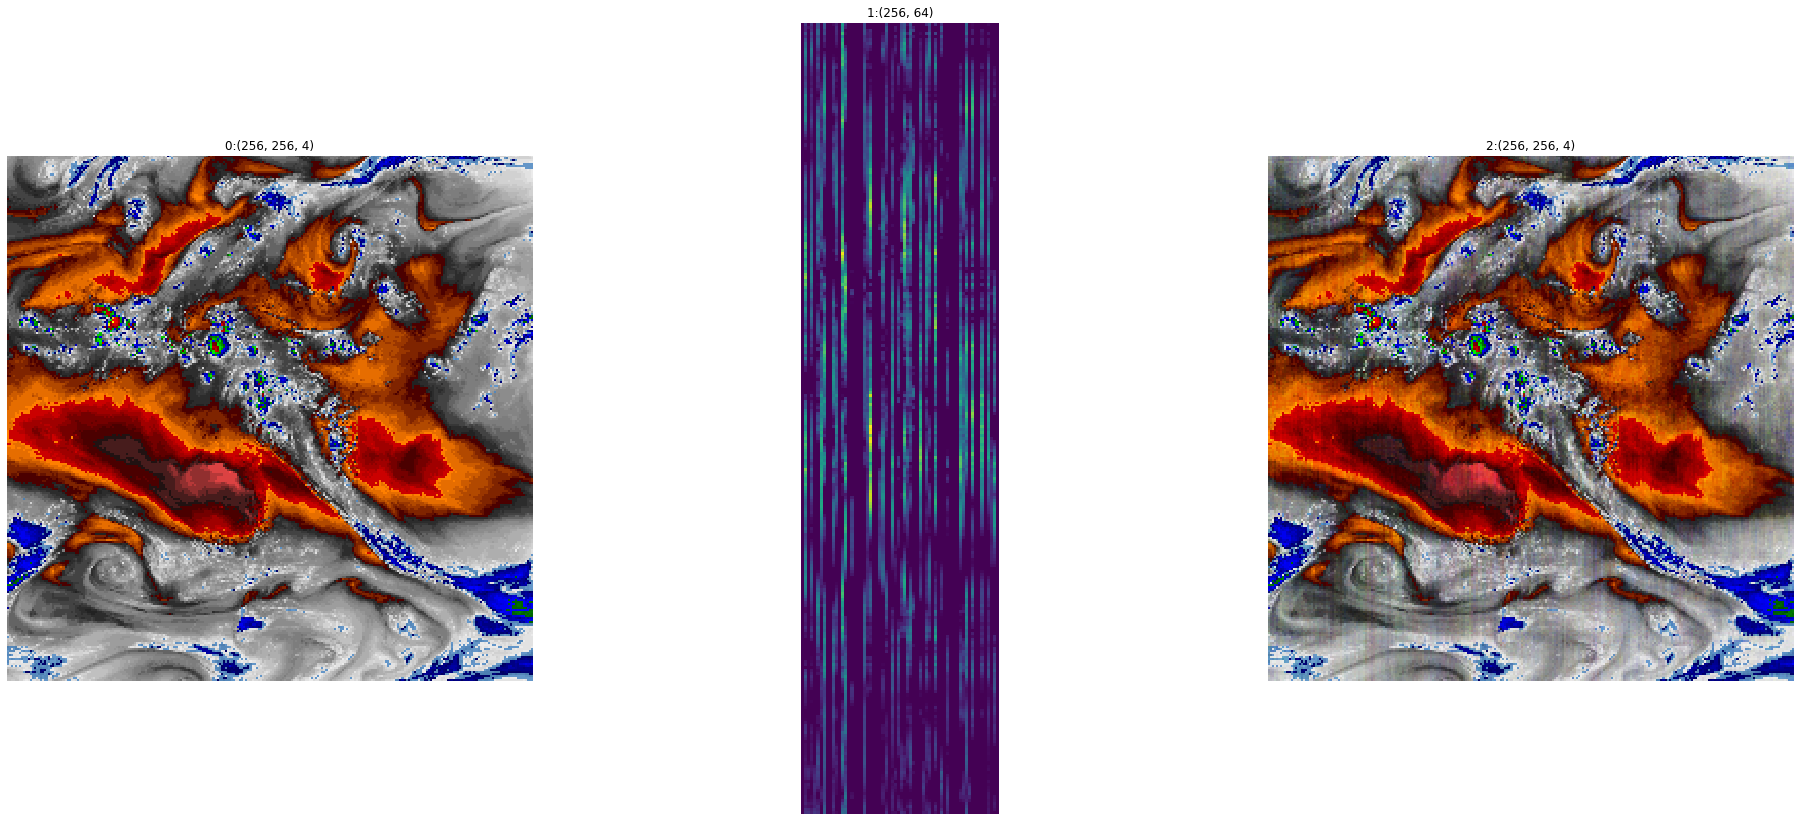

In [52]:
images = main()
plot_all(images)

Load model

In [0]:
# model_decoder_save = load_model('./models_h5/decoder__3_7880292.h5')
# model_decoder_save.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# img_encoded = np.load('./data_npy/_3_7880292.npy')
# img_decoded = model_decoder_save.predict(img_encoded)

# with open("./shapes_sizes_json/original__3_7880292.json", "r") as read_file:
#     data = json.load(read_file)

# test_encoder_result = img_decoded.reshape(data['shape_0'], data['shape_1'], data['shape_2'])

In [0]:
# plt.imshow(test_encoder_result)

In [0]:
# plt.imshow(img_encoded)